<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

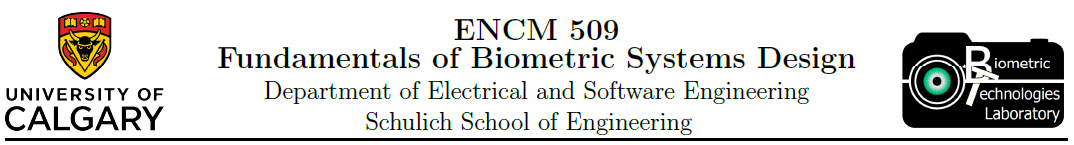

# ENCM 509 - Lab 2 Report

**Student Names**


**Mushtaba Al Yasseen (30094000)**
\
**Usman Khan (30092202)**

Importing all necessary libraries

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure
import scipy.linalg as la

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from utils_cm import plot_confusion_matrix

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# **Introduction:**

## **Exercise 1:**

In [22]:
# M could be large (for example, 16: 8 of yours and 8 of a friend)
# for At&T dataset there are 10 faces per subject. 
# However, we are going to load only the first 9
# the 10th image will be used to compare later on.
M = 9

# can be any number that is close to the std and mean of most of the images.
um = 100
ustd = 80

Before performing classification (matching), we will build an image gallery first

In [23]:
def build_image_gallery(path, irow, icol):
    # allocation of vector that will have all images
    S = np.zeros((irow*icol, M)) # img matrix

    plt.figure(figsize=(8,8))
    for i in range(1,M+1):
        img = imread(path + '{}.pgm'.format(i), as_gray=True)
        
        plt.subplot(3,3,i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        
        # reshape(img',irow*icol,1); 
        # creates a (N1*N2)x1 vector
        temp = np.reshape(img, (irow*icol,1))
        S[:,i-1] = temp[:,0]
    # after finishing the sequence, S is a N1*N2xM matrix 

    print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))

    # Here we **normalize** all images by changing the *mean* and *std* of each one. This is done to reduce the error due to lighting conditions and background.

    # looping over all the loaded images in S to normalize
    for i in range(S.shape[1]):
        temp = S[:,i]
        m = np.mean(temp)
        st = np.std(temp)
        # calculation where are defined the new pixels intensities
        S[:,i] = (temp - m) * ustd / st + um

    # calculates the mean of each row instead of each column
    m = np.mean(S, axis=1)
    # converts to unsigned 8-bit integer. Values range from 0 to 255
    m = np.uint8(np.abs(m)).reshape(-1,1)

    # #### Creating covariance matrix  L, Sort and eliminate zero eigenvalue, Normalization of eigenvectors

    dbx = S.copy()
    A = dbx.T
    L = np.matmul(A, A.T)

    # vv is the eigenvector for L
    # dd is the eigenvalue for  L = dbx.T*dbx
    dd, vv = la.eig(L)


    v = np.zeros(vv.shape)
    d = np.zeros(dd.shape)

    for i in range(vv.shape[1]):
        if (dd[i] > 1e-4):
            v[:,i] = vv[:,i]
            d[i] = dd[i]
            
    # sort d in ascending order
    index = np.argsort(d)
    B = d[index]
    ind = np.zeros(index.shape).astype(int)
    dtemp = np.zeros(index.shape)
    vtemp = np.zeros(v.shape)

    idx_len = len(index)
    for i in range(idx_len):
        dtemp[i] = B[idx_len-1-i]
        ind[i] = idx_len-1-index[i]
        vtemp[:,ind[i]] = v[:,i]

    d = dtemp
    v = vtemp

    for i in range(v.shape[1]):
        kk = v[:,i]
        temp = np.sqrt(np.sum(np.power(kk,2)))
        v[:,i] = v[:,i] / temp
        
    # Eigenvectors of C matrix
    u = np.zeros(dbx.shape)
    for i in range(v.shape[1]):
        temp = np.sqrt(d[i])
        u[:,i] = np.matmul(dbx, v[:,i]) / temp
        
    for i in range(u.shape[1]):
        kk = u[:,i]
        temp = np.sqrt(np.sum(np.power(kk,2)))
        u[:,i] = u[:,i] / temp

    # #### Find the weight of each face in the training set
        
    omega = np.zeros((M,M))
    WW = np.zeros((M,1))

    for h in range(dbx.shape[1]):
        for i in range(u.shape[1]):
            t = u[:,i].T
            WeightOfImage = np.dot(t, dbx[:,h].T)
            WW[i] = WeightOfImage
        omega[:,h] = WW[:,0]

    return m, u, omega

Now we will create a method to calculate the euclidean distances of the images

In [24]:
def plot_images(InputImage, ReshapedImage):
    plt.figure(figsize=(6,6))

    # Plot input image
    plt.subplot(1,2,1)
    plt.imshow(InputImage, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    # Plot reconstructed image
    plt.subplot(1,2,2)
    plt.imshow(ReshapedImage, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.show()

def plot_euclidean_distances(eSameSubject, MinimumValue, MaximumValue):

    labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

    plt.bar(np.arange(len(eSameSubject)), eSameSubject.flatten(), tick_label=labels)
    plt.ylim([10000, 16000])
    plt.xlabel('Image #')
    plt.ylabel('Distance')
    plt.title('Euclidean Distances: Same subject\n'\
            'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));
    
    plt.show()

def calculate_euclidean_distance(InputImage, m, u, omega, irow, icol):

    InImage = np.reshape(InputImage, (irow*icol,1))

    # Normalization
    temp = InImage
    me = np.mean(temp)
    st = np.std(temp)
    temp = (temp-me) * ustd/st + um
    NormImage = temp

    # Finding Difference: NormalizedImage - MeanImage
    Difference = temp - m

    p = np.zeros((u.shape[1],1))
    for i in range(u.shape[1]):
        # dot returns scalar vector product
        pare = np.dot(u[:,i], NormImage) 
        p[i] = pare

    # m is the mean image, u is the eigenvector
    ReshapedImage = m + np.matmul(u, p) 
    ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

    plot_images(InputImage, ReshapedImage)

    InImWeight = np.zeros((M,1))

    for i in range(u.shape[1]):
        t = u[:,i].reshape(-1,1).T
        # scalar vector product of vectors t and Difference
        WeightOfInputImage = np.dot(t, Difference) 
        InImWeight[i] = WeightOfInputImage

    eSameSubject = np.zeros((M,1))

    for i in range(omega.shape[1]):
        q = omega[:,i].reshape(-1,1)
        DiffWeight = InImWeight - q
        mag = np.linalg.norm(DiffWeight)
        eSameSubject[i] = mag

    # max/min Euclidean distance
    MaximumValue = np.max(eSameSubject) 
    MinimumValue = np.min(eSameSubject)

    plot_euclidean_distances(eSameSubject, MinimumValue, MaximumValue)

    return eSameSubject

#### Subject #1 - Gallery Creation

Size of each image: (112, 92) 10304


C:\Users\musht\AppData\Local\Temp\ipykernel_1328\2386427840.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = dd[i]


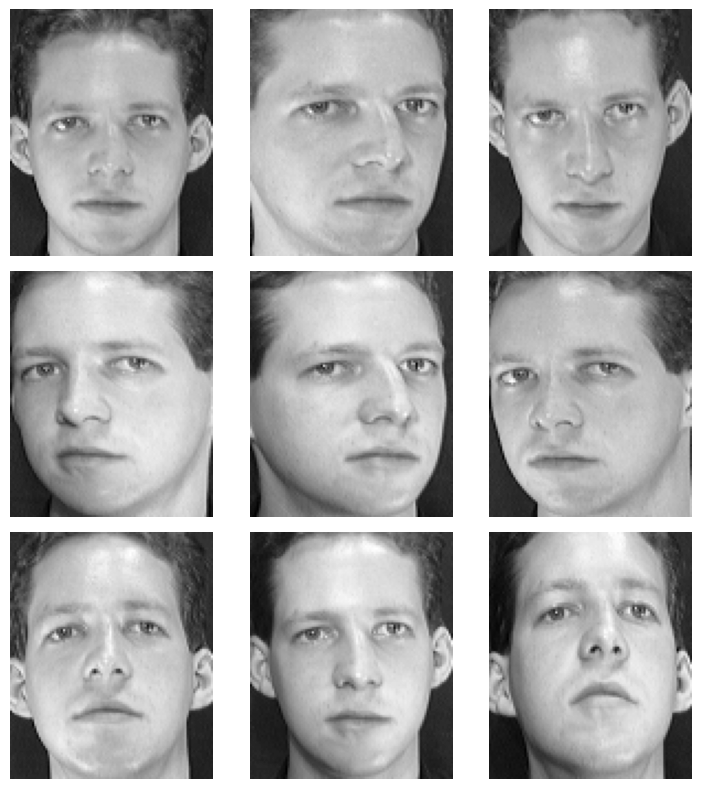

In [25]:
# You can specify you directory here, please, change the string below:
path = './ATT dataset/s1/'

# loading only one image to get the dimensions
# you can use images .jpg and .ng as well
img = imread(path + '1.pgm', as_gray=True)

# get the number of rows (irow) and columns (icol). 
# these values must to be the same for all images
irow, icol = img.shape

m, u, omega = build_image_gallery(path, irow, icol)

#### Subject #1 - 10th Image As Probe

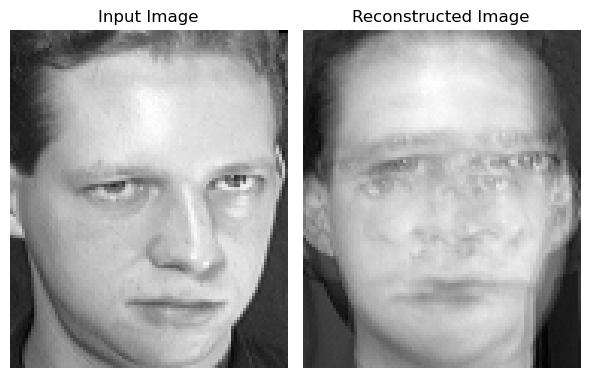

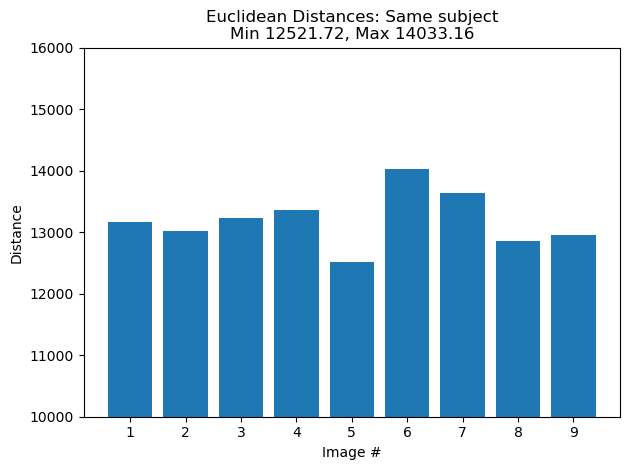

In [26]:
# using the last image of subject #1
InputPath = './ATT dataset/s1/'
InputImage = imread(InputPath + '10.pgm', as_gray=True)
eS1And10th = calculate_euclidean_distance(InputImage, m, u, omega, irow, icol)

#### Subject #1 - Subject 4 As Probe

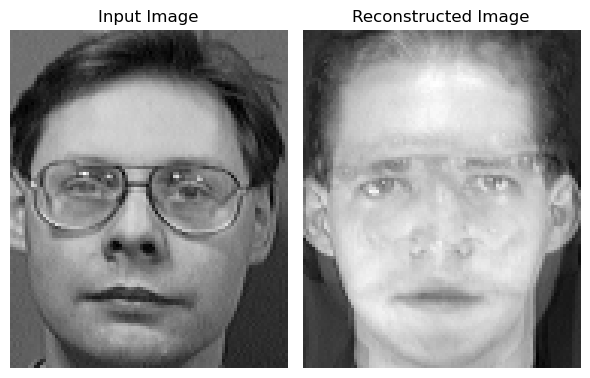

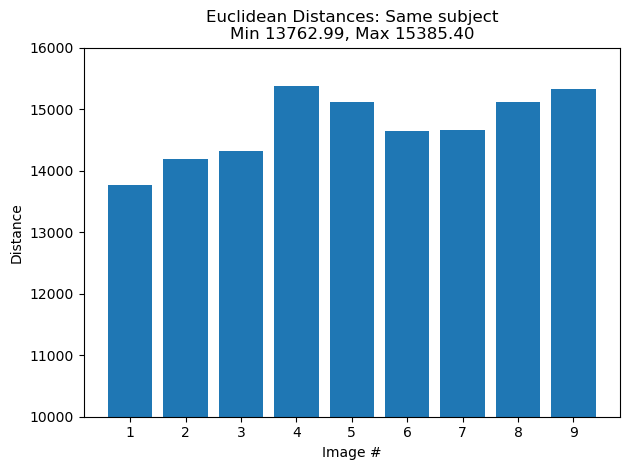

In [27]:
# using the last image of subject #1
InputPath = './ATT dataset/s4/'
InputImage = imread(InputPath + '1.pgm', as_gray=True)
eS1AndS4NotKnown = calculate_euclidean_distance(InputImage, m, u, omega, irow, icol)

#### Subject #1 - Subject 8 As Probe

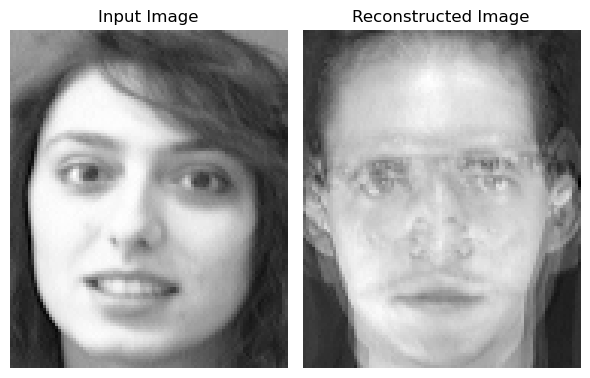

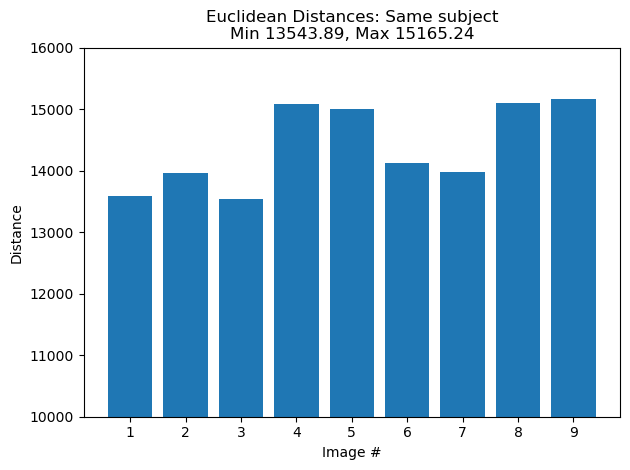

In [28]:
# using the last image of subject #1
InputPath = './ATT dataset/s8/'
InputImage = imread(InputPath + '1.pgm', as_gray=True)
eS1AndS8NotKnown = calculate_euclidean_distance(InputImage, m, u, omega, irow, icol)

#### Subject #1 - Not A Face As Probe

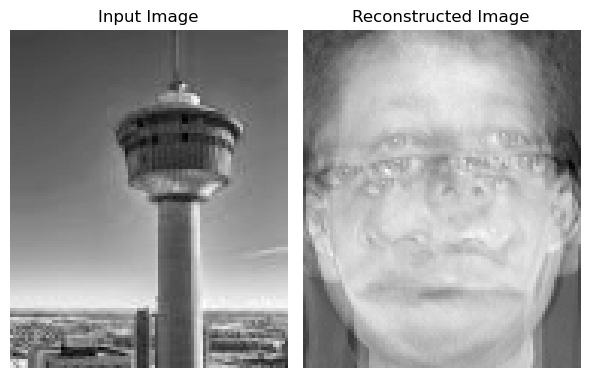

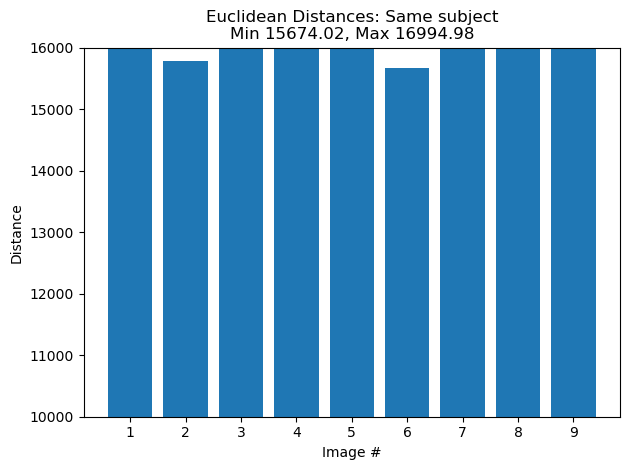

In [29]:
# using the last image of subject #1
InputPath = './CalgaryTower.jpg'
InputImage = imread(InputPath, as_gray=True)
eS1NotAFace = calculate_euclidean_distance(InputImage, m, u, omega, irow, icol)

#### Subject #2 - Gallery Creation

Size of each image: (112, 92) 10304


C:\Users\musht\AppData\Local\Temp\ipykernel_1328\2386427840.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = dd[i]


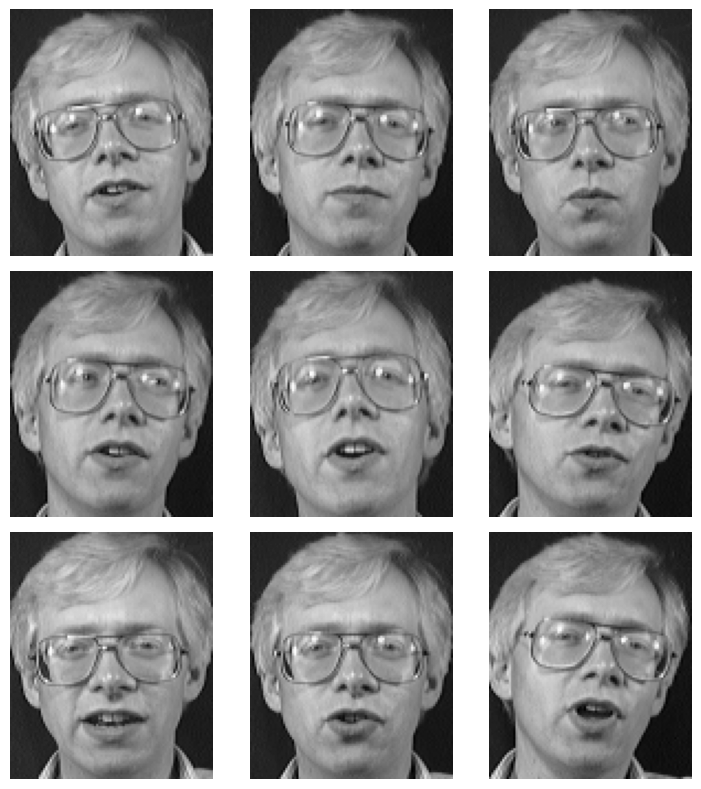

In [30]:
# You can specify you directory here, please, change the string below:
path = './ATT dataset/s2/'

# loading only one image to get the dimensions
# you can use images .jpg and .ng as well
img = imread(path + '1.pgm', as_gray=True)

# get the number of rows (irow) and columns (icol). 
# these values must to be the same for all images
irow, icol = img.shape

m, u, omega = build_image_gallery(path, irow, icol)

#### Subject #2 - 10th Image As Probe

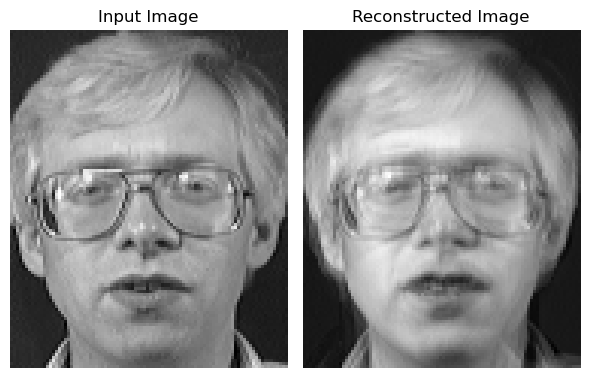

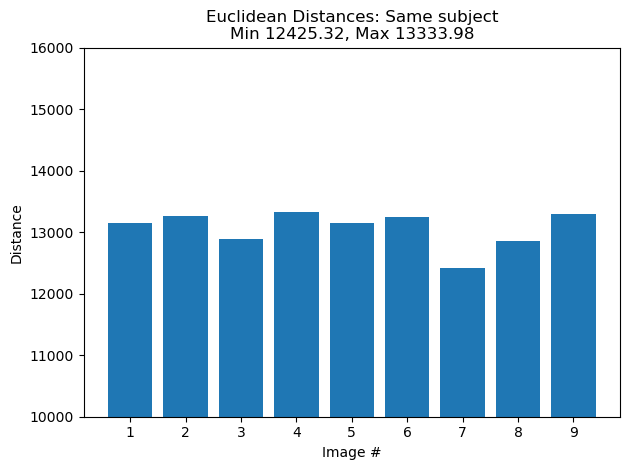

In [31]:
# using the last image of subject #1
InputPath = './ATT dataset/s2/'
InputImage = imread(InputPath + '10.pgm', as_gray=True)
eS2And10th = calculate_euclidean_distance(InputImage, m, u, omega, irow, icol)

#### Subject #2 - Subject 12 As Probe

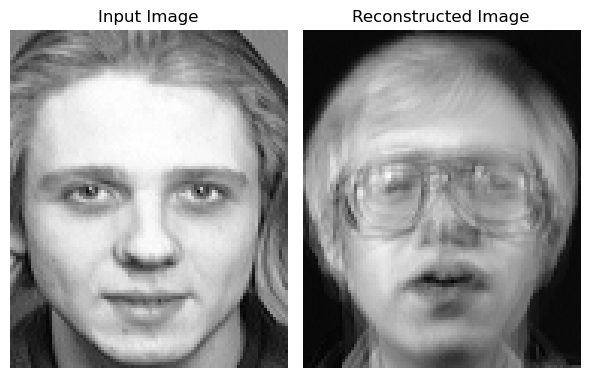

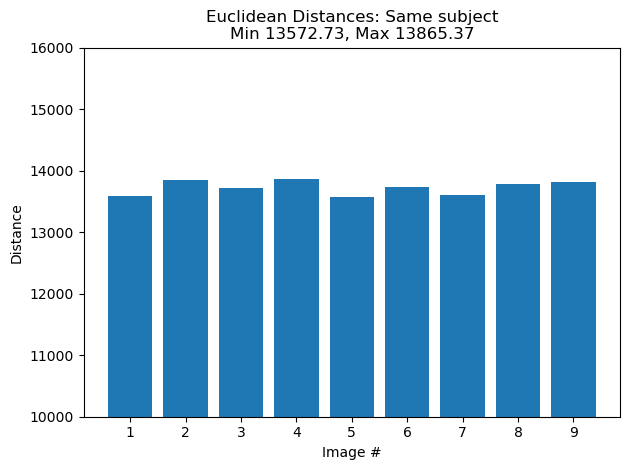

In [32]:
# using the last image of subject #1
InputPath = './ATT dataset/s12/'
InputImage = imread(InputPath + '1.pgm', as_gray=True)
eS2AndS12NotKnown = calculate_euclidean_distance(InputImage, m, u, omega, irow, icol)

#### Subject #2 - Subject 14 As Probe

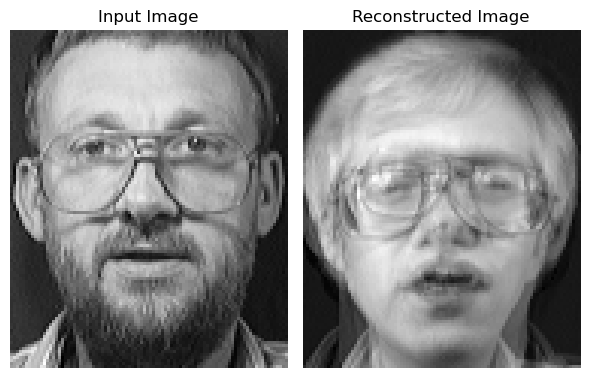

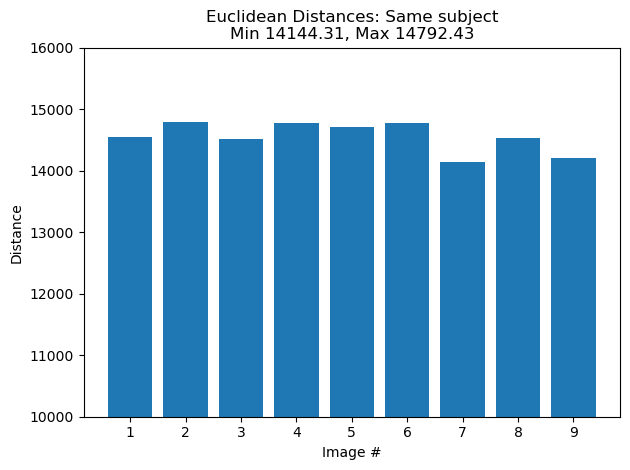

In [33]:
# using the last image of subject #1
InputPath = './ATT dataset/s14/'
InputImage = imread(InputPath + '1.pgm', as_gray=True)
eS2AndS14NotKnown = calculate_euclidean_distance(InputImage, m, u, omega, irow, icol)

#### Subject #2 - Not A Face As Probe

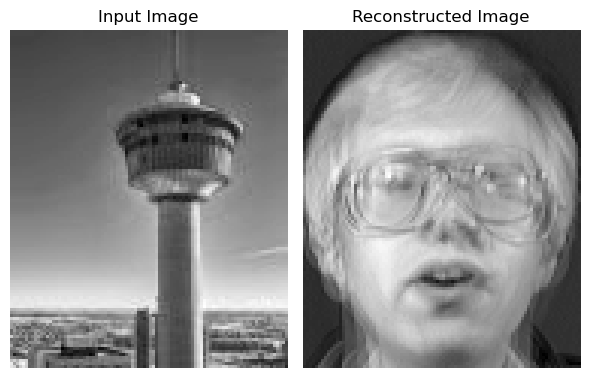

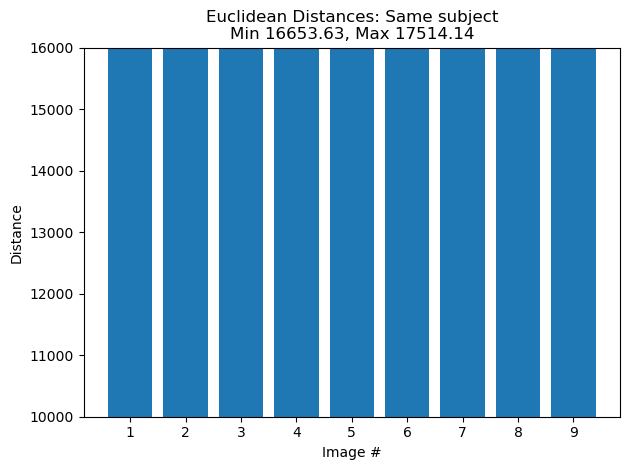

In [34]:
# using the last image of subject #1
InputPath = './CalgaryTower.jpg'
InputImage = imread(InputPath, as_gray=True)
eS2NotAFace = calculate_euclidean_distance(InputImage, m, u, omega, irow, icol)

#### Subject #3 - Gallery Creation

Size of each image: (112, 92) 10304


C:\Users\musht\AppData\Local\Temp\ipykernel_1328\2386427840.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = dd[i]


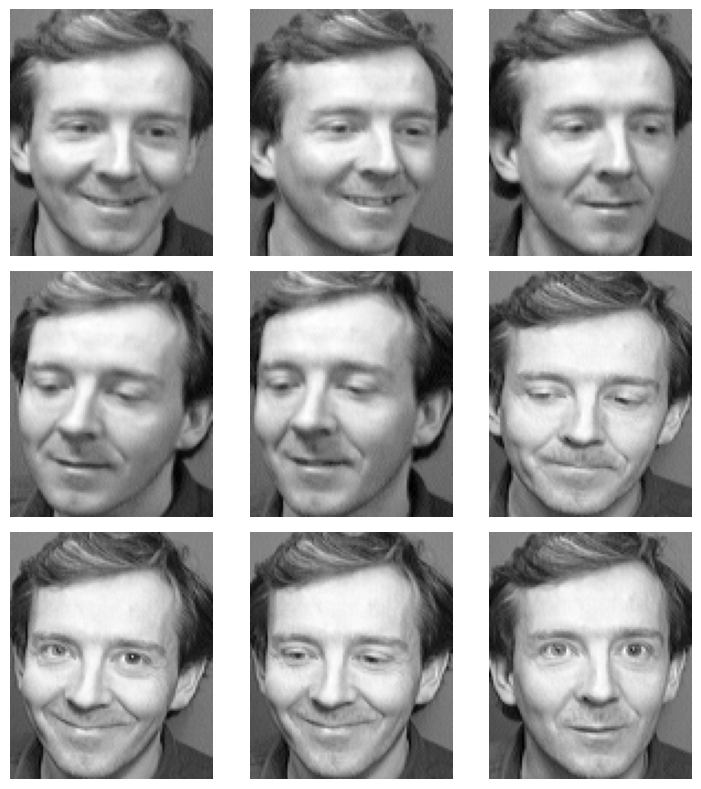

In [35]:
# You can specify you directory here, please, change the string below:
path = './ATT dataset/s3/'

# loading only one image to get the dimensions
# you can use images .jpg and .ng as well
img = imread(path + '1.pgm', as_gray=True)

# get the number of rows (irow) and columns (icol). 
# these values must to be the same for all images
irow, icol = img.shape

m, u, omega = build_image_gallery(path, irow, icol)

#### Subject #3 - 10th Image As Probe

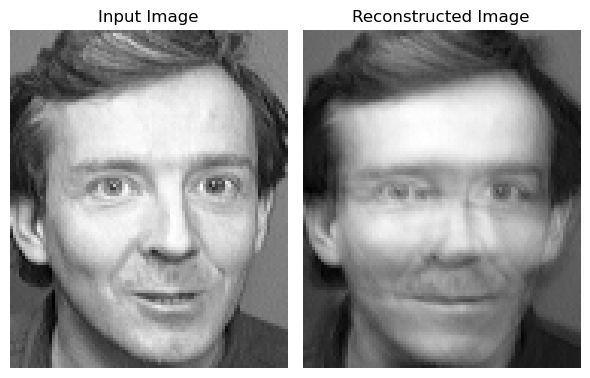

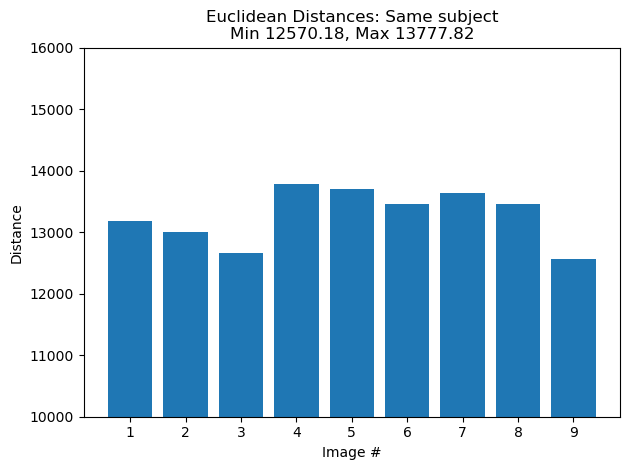

In [36]:
# using the last image of subject #1
InputPath = './ATT dataset/s3/'
InputImage = imread(InputPath + '10.pgm', as_gray=True)
eS3And10th = calculate_euclidean_distance(InputImage, m, u, omega, irow, icol)

#### Subject #3 - Subject 18 As Probe

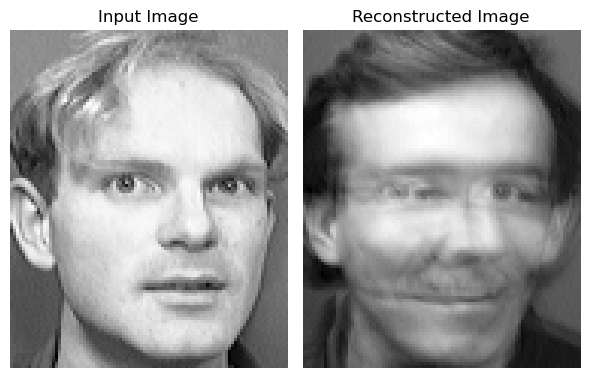

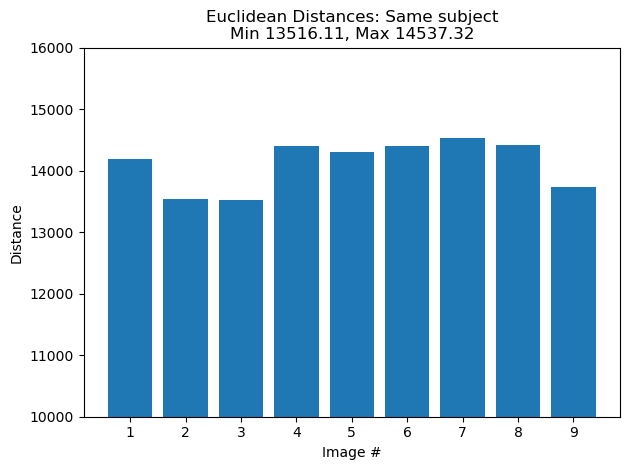

In [37]:
# using the last image of subject #1
InputPath = './ATT dataset/s18/'
InputImage = imread(InputPath + '1.pgm', as_gray=True)
eS3AndS18NotKnown = calculate_euclidean_distance(InputImage, m, u, omega, irow, icol)

#### Subject #3 - Subject 20 As Probe

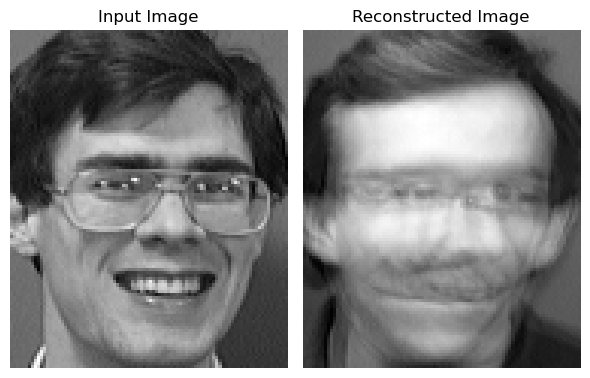

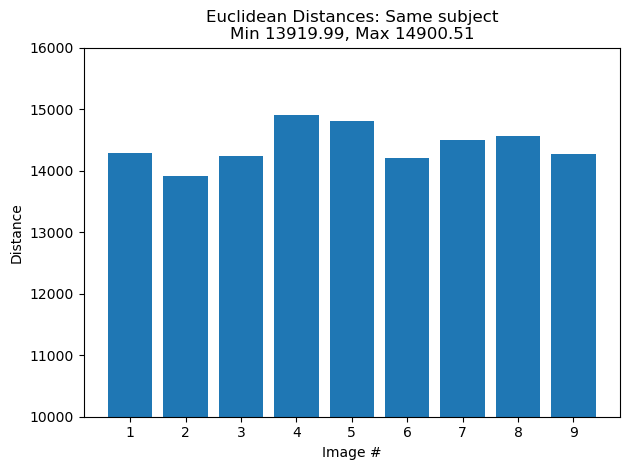

In [38]:
# using the last image of subject #1
InputPath = './ATT dataset/s20/'
InputImage = imread(InputPath + '1.pgm', as_gray=True)
eS3AndS20NotKnown = calculate_euclidean_distance(InputImage, m, u, omega, irow, icol)

#### Subject #3 - Not A Face As Probe

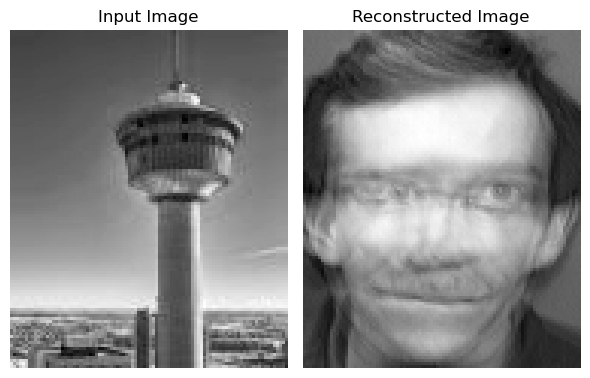

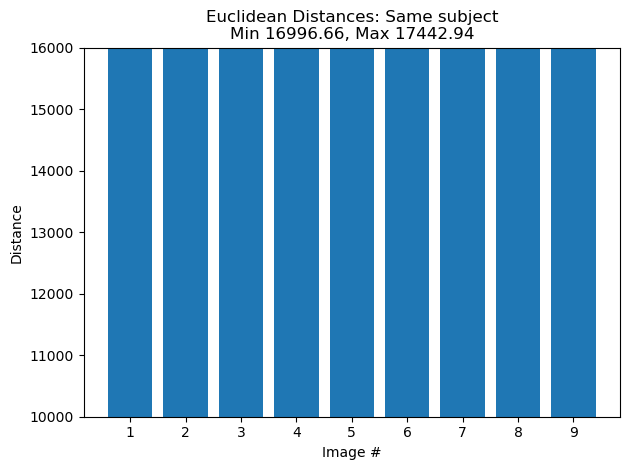

In [39]:
# using the last image of subject #1
InputPath = './CalgaryTower.jpg'
InputImage = imread(InputPath, as_gray=True)
eS3NotAFace = calculate_euclidean_distance(InputImage, m, u, omega, irow, icol)

#### Analysis Of Data:

As shown in the calculations of the euclidean distances above, it is evident that there is a common pattern among all the probe images. For instance, for probe images that are known to the dataset, the minimum and maximum euclidean distances are much lower, however, as we start to introduce probe images that are not in the dataset and are not images, then we start to see the euclidean distances start to increase. This makes sense as when the euclidean distances are lower, it indicates more similarity between the two images. An outlier that presents this fact most clearly is when we used subject #12 (an image that is not in the dataset) against subject #2. The reason why this probe image had low euclidean distances could be due to the similarities between the two images (hair and facial structure), enhancing the liklihood of falsely "accepting" these type of images based on the thresholds chosen.

## **Exercise 2:**

We will now determine the first and second thresholds taken from the euclidean distances of the probe images. Firstly, to determine the first threshold, we will analyze the maximum of the euclidean distances for the probe images known to the dataset. For all three subjects, we had euclidean distances of $14033.16$, $13333.98$, and $13777.82$ for probe images known to the dataset. Thus, we will select the maximum of the euclidean distances as the first threshold which is $14034$. Now, for the second threshold we will do something similar, except that we will take the maximum of the euclidean distances of unknown faces to the dataset which turns out to be $15386$.

In [41]:
# Set Threshold Values
threshold1 = 14034
threshold2 = 15386

def decision_output(distances):
    mean_of_distances = np.mean(distances);
    if (mean_of_distances <= threshold1):
        print('Image is in the database')
    elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
        print('Image is a face but not in the database')
    elif (mean_of_distances > threshold2):
        print('Image is not a face')

In [47]:
print("Subject #1----------")
decision_output(eS1And10th)
decision_output(eS1AndS4NotKnown)
decision_output(eS1AndS8NotKnown)
decision_output(eS1NotAFace)
print("\n")

print("Subject #2----------")
decision_output(eS2And10th)
decision_output(eS2AndS12NotKnown)
decision_output(eS2AndS14NotKnown)
decision_output(eS2NotAFace)
print("\n")

print("Subject #3----------")
decision_output(eS3And10th)
decision_output(eS3AndS18NotKnown)
decision_output(eS3AndS20NotKnown)
decision_output(eS3NotAFace)

Subject #1----------
Image is in the database
Image is a face but not in the database
Image is a face but not in the database
Image is not a face


Subject #2----------
Image is in the database
Image is in the database
Image is a face but not in the database
Image is not a face


Subject #3----------
Image is in the database
Image is a face but not in the database
Image is a face but not in the database
Image is not a face


#### Analysis Of Data:

As evidently shown above, the chosen thresholds play a significant role in providing a correct decision output for each of the probe images. Overall, the thresholds that we have chosen based on the maximum euclidean distances does a good job, as we were able to accurately provide the correct decision output for all the probe images except for one. This is because we "accept" any image that is less than or equal to threshold1, while "rejecting" any image that is greater than threshold2. However, this procedure also has a flaw which needs improvement. For instance, for subject #2, we used subject #12 which is not known to the database, but, because of similarities between the two images (hair and facial structure), the euclidean distance was actually lower than threshold1, causing us to falsely "accept" the image. This is the trickiest part of choosing thresholds, as you don't want a threshold1 too high, which would falsely accept images, and at the same time you don't want a threshold1 too low, which would falsely reject images. As a result, you need to keep a stable middle ground between the two, while knowing that these flaws can occur.

## **Exercise 3:**

#### Analysis Of Data:

## **Exercise 4:**

#### Analysis Of Data:

# **Conclusion:**